In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install librosa

In [ ]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/content/drive/My Drive/Ravdess/03-01-01-01-01-01-01.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


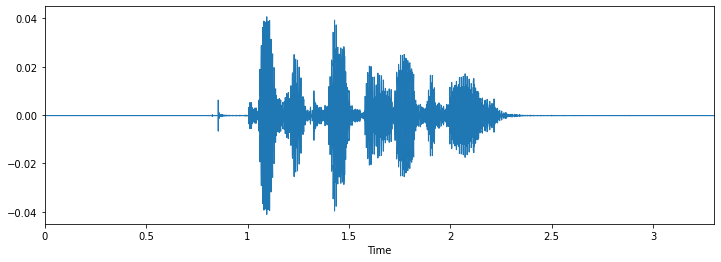

In [ ]:
% pylab inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
import time

path = '/content/drive/My Drive/Ravdess/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 505.6281886100769 seconds ---


In [ ]:
X, y = zip(*lst)

In [ ]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((1440, 40), (1440,))

#Decision Tree

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
predictions = dtree.predict(X_test)

Let's go with our classification report.

Before we start, a quick reminder of the classes we are trying to predict:

emotions = { "neutral": "0", "calm": "1", "happy": "2", "sad": "3", "angry": "4", "fearful": "5", "disgust": "6", "surprised": "7" }

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.34      0.37      0.35        30
           1       0.51      0.59      0.55        51
           2       0.35      0.32      0.34        71
           3       0.29      0.22      0.25        67
           4       0.43      0.44      0.44        63
           5       0.34      0.37      0.35        59
           6       0.38      0.30      0.34        76
           7       0.27      0.36      0.31        59

    accuracy                           0.36       476
   macro avg       0.36      0.37      0.37       476
weighted avg       0.36      0.36      0.36       476



#Random Forest
In this second approach, I switched to a random forest classifier and I made a gridsearch to make some hyperparameters tuning.

The gridsearch is not shown in the code below otherwise the notebook will require too much time to run.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [ ]:
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [ ]:
predictions = rforest.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.03      0.06        30
           1       0.36      0.92      0.52        51
           2       0.38      0.21      0.27        71
           3       0.35      0.31      0.33        67
           4       0.77      0.57      0.65        63
           5       0.48      0.49      0.49        59
           6       0.49      0.38      0.43        76
           7       0.47      0.64      0.55        59

    accuracy                           0.45       476
   macro avg       0.54      0.45      0.41       476
weighted avg       0.51      0.45      0.43       476




#Neural network
Let's build our neural network!

To do so, we need to expand the dimensions of our array, adding a third one using the numpy "expand_dims" feature.

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape, x_testcnn.shape

((964, 40, 1), (476, 40, 1))

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
activation_7 (Activation)    (None, 40, 64)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_8 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 128)          

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
61/61 [==============================] - 1s 16ms/step - loss: 2.3063 - accuracy: 0.2189 - val_loss: 1.9947 - val_accuracy: 0.2101
Epoch 2/200
61/61 [==============================] - 1s 16ms/step - loss: 2.2833 - accuracy: 0.2012 - val_loss: 2.0371 - val_accuracy: 0.1933
Epoch 3/200
61/61 [==============================] - 1s 16ms/step - loss: 2.2256 - accuracy: 0.2106 - val_loss: 2.0629 - val_accuracy: 0.2038
Epoch 4/200
61/61 [==============================] - 1s 16ms/step - loss: 2.1696 - accuracy: 0.2158 - val_loss: 1.9853 - val_accuracy: 0.2605
Epoch 5/200
61/61 [==============================] - 1s 16ms/step - loss: 2.1066 - accuracy: 0.2251 - val_loss: 1.9387 - val_accuracy: 0.2332
Epoch 6/200
61/61 [==============================] - 1s 15ms/step - loss: 2.0853 - accuracy: 0.2334 - val_loss: 1.9095 - val_accuracy: 0.2374
Epoch 7/200
61/61 [==============================] - 1s 15ms/step - loss: 2.0980 - accuracy: 0.2293 - val_loss: 1.9954 - val_accuracy: 0.2290
Epoch 

Let's plot the loss:

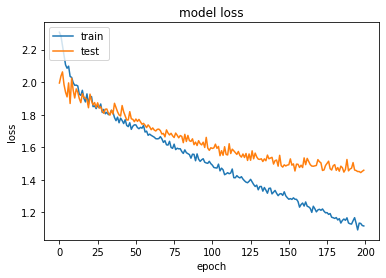

In [ ]:
# plt.plot(cnnhistory.history['loss'])
# plt.plot(cnnhistory.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

And now let's plot the accuracy:

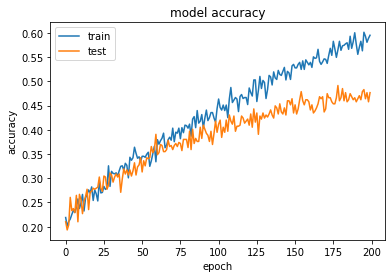

In [ ]:
# plt.plot(cnnhistory.history['acc'])
# plt.plot(cnnhistory.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('acc')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
predictions = model.predict_classes(x_testcnn)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
predictions

array([3, 7, 2, 3, 6, 3, 2, 2, 1, 1, 0, 4, 2, 4, 2, 0, 5, 6, 2, 4, 0, 6,
       1, 4, 7, 4, 0, 2, 7, 0, 7, 7, 4, 1, 6, 2, 0, 2, 0, 5, 3, 1, 2, 4,
       0, 5, 0, 2, 1, 7, 1, 7, 3, 3, 3, 6, 4, 3, 2, 2, 1, 4, 6, 3, 1, 2,
       4, 4, 2, 2, 3, 2, 6, 7, 2, 4, 0, 4, 0, 0, 0, 3, 7, 2, 1, 7, 1, 1,
       7, 7, 6, 7, 1, 7, 2, 2, 3, 1, 3, 3, 5, 7, 7, 4, 7, 1, 7, 2, 1, 7,
       4, 2, 1, 4, 2, 4, 0, 1, 2, 0, 3, 2, 0, 2, 7, 6, 5, 3, 1, 6, 3, 3,
       2, 2, 4, 6, 0, 2, 5, 5, 1, 2, 1, 5, 3, 1, 4, 4, 3, 3, 5, 2, 2, 1,
       4, 7, 5, 6, 6, 7, 2, 2, 2, 1, 5, 7, 1, 7, 2, 2, 6, 2, 3, 4, 4, 7,
       5, 4, 4, 7, 4, 4, 0, 5, 6, 2, 2, 6, 1, 3, 5, 5, 2, 2, 2, 2, 6, 0,
       7, 6, 3, 6, 5, 3, 4, 7, 5, 2, 4, 4, 3, 3, 3, 2, 0, 2, 7, 1, 7, 2,
       4, 2, 7, 7, 7, 2, 4, 3, 2, 3, 3, 2, 1, 2, 4, 2, 2, 1, 2, 2, 7, 0,
       2, 2, 6, 1, 4, 3, 5, 6, 3, 2, 4, 2, 3, 6, 7, 1, 5, 0, 2, 4, 4, 1,
       5, 1, 7, 2, 4, 1, 2, 3, 7, 6, 1, 2, 6, 2, 4, 4, 4, 2, 3, 4, 6, 6,
       0, 1, 4, 6, 2, 2, 2, 4, 3, 6, 4, 1, 3, 3, 7,

In [ ]:
y_test

array([1, 7, 1, 3, 0, 6, 2, 5, 1, 4, 1, 3, 1, 4, 7, 0, 5, 6, 5, 5, 5, 1,
       2, 4, 6, 2, 1, 6, 6, 0, 7, 7, 6, 3, 1, 2, 1, 0, 6, 2, 5, 5, 4, 4,
       0, 5, 6, 2, 1, 6, 5, 7, 5, 3, 6, 6, 7, 5, 2, 2, 1, 4, 6, 2, 1, 0,
       4, 7, 4, 2, 3, 7, 6, 7, 6, 6, 6, 4, 3, 1, 6, 0, 7, 3, 1, 7, 1, 1,
       3, 7, 6, 7, 3, 7, 2, 7, 3, 3, 2, 3, 5, 7, 3, 6, 2, 1, 7, 3, 3, 7,
       4, 3, 1, 2, 7, 4, 0, 0, 6, 3, 3, 2, 1, 0, 7, 6, 2, 3, 1, 6, 3, 5,
       0, 6, 6, 7, 0, 3, 5, 5, 1, 2, 0, 6, 1, 1, 4, 4, 6, 3, 5, 6, 2, 3,
       4, 7, 5, 6, 6, 7, 4, 4, 2, 5, 5, 7, 1, 7, 7, 1, 7, 7, 5, 4, 4, 0,
       5, 4, 2, 1, 4, 2, 2, 3, 6, 1, 2, 6, 1, 6, 6, 2, 3, 4, 2, 2, 6, 0,
       7, 2, 2, 5, 3, 3, 3, 7, 5, 2, 7, 4, 5, 1, 2, 5, 3, 4, 6, 3, 2, 3,
       6, 7, 4, 7, 6, 5, 4, 5, 7, 0, 3, 2, 1, 7, 7, 2, 2, 0, 5, 7, 6, 1,
       4, 2, 4, 1, 4, 5, 7, 6, 1, 2, 4, 4, 7, 1, 7, 3, 3, 0, 2, 4, 3, 1,
       5, 4, 7, 3, 6, 6, 2, 3, 5, 0, 3, 4, 6, 6, 2, 4, 4, 6, 1, 4, 6, 6,
       6, 3, 4, 1, 7, 2, 5, 4, 3, 6, 4, 1, 5, 0, 5,

In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
new_Ytest

array([1, 7, 1, 3, 0, 6, 2, 5, 1, 4, 1, 3, 1, 4, 7, 0, 5, 6, 5, 5, 5, 1,
       2, 4, 6, 2, 1, 6, 6, 0, 7, 7, 6, 3, 1, 2, 1, 0, 6, 2, 5, 5, 4, 4,
       0, 5, 6, 2, 1, 6, 5, 7, 5, 3, 6, 6, 7, 5, 2, 2, 1, 4, 6, 2, 1, 0,
       4, 7, 4, 2, 3, 7, 6, 7, 6, 6, 6, 4, 3, 1, 6, 0, 7, 3, 1, 7, 1, 1,
       3, 7, 6, 7, 3, 7, 2, 7, 3, 3, 2, 3, 5, 7, 3, 6, 2, 1, 7, 3, 3, 7,
       4, 3, 1, 2, 7, 4, 0, 0, 6, 3, 3, 2, 1, 0, 7, 6, 2, 3, 1, 6, 3, 5,
       0, 6, 6, 7, 0, 3, 5, 5, 1, 2, 0, 6, 1, 1, 4, 4, 6, 3, 5, 6, 2, 3,
       4, 7, 5, 6, 6, 7, 4, 4, 2, 5, 5, 7, 1, 7, 7, 1, 7, 7, 5, 4, 4, 0,
       5, 4, 2, 1, 4, 2, 2, 3, 6, 1, 2, 6, 1, 6, 6, 2, 3, 4, 2, 2, 6, 0,
       7, 2, 2, 5, 3, 3, 3, 7, 5, 2, 7, 4, 5, 1, 2, 5, 3, 4, 6, 3, 2, 3,
       6, 7, 4, 7, 6, 5, 4, 5, 7, 0, 3, 2, 1, 7, 7, 2, 2, 0, 5, 7, 6, 1,
       4, 2, 4, 1, 4, 5, 7, 6, 1, 2, 4, 4, 7, 1, 7, 3, 3, 0, 2, 4, 3, 1,
       5, 4, 7, 3, 6, 6, 2, 3, 5, 0, 3, 4, 6, 6, 2, 4, 4, 6, 1, 4, 6, 6,
       6, 3, 4, 1, 7, 2, 5, 4, 3, 6, 4, 1, 5, 0, 5,

Okay, now we can display the classification report:

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.31      0.40      0.35        30
           1       0.53      0.53      0.53        51
           2       0.34      0.56      0.42        71
           3       0.43      0.39      0.41        67
           4       0.57      0.65      0.61        63
           5       0.61      0.42      0.50        59
           6       0.60      0.33      0.42        76
           7       0.61      0.53      0.56        59

    accuracy                           0.48       476
   macro avg       0.50      0.48      0.47       476
weighted avg       0.51      0.48      0.48       476



In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[12  4  8  3  0  0  2  1]
 [ 8 27  4  5  0  0  6  1]
 [ 4  2 40  4  9  6  4  2]
 [ 6 10 12 26  4  5  0  4]
 [ 0  3 13  2 41  0  2  2]
 [ 1  3 13 12  2 25  1  2]
 [ 6  2 13  8 10  4 25  8]
 [ 2  0 16  1  6  1  2 31]]


#Save the model

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/content/drive/My Drive/Ravdess_model'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/Ravdess_model/Emotion_Voice_Detection_Model.h5 


#Reloading the model to test it

In [ ]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Ravdess_model/Emotion_Voice_Detection_Model.h5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_3 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_4 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 128)           

#Checking the accuracy of the loaded model

In [ ]:
# loss, acc = loaded_model.evaluate(x_testcnn, y_test)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))

loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

15/15 [==============================] - 0s 2ms/step - loss: 0.7073 - accuracy: 0.0693
Restored model, accuracy:  6.93%
